# Кластеризация. Домашка

## Совсем простая рекомендательная система

На основе оценок аниме, которые ставят пользователи систем типа [MAL](https://myanimelist.net/), можно строить разные кластеры данных:
- кластеры похожих людей. Похожие значит, что эти люди ставят похожие рейтинги аниме.
- кластеры похожих аниме. Похожие значит что люди оценивают их похоже.
- кластеры похожих жанров. Но похожие не в обычном смысле, а в смысле, что люди которые смотрят жанр А любят смотреть жанр Б.

и т.д.

### Полезная литература

- [Лекция 8. Рекомендательный системы](https://www.youtube.com/watch?v=Te_6TqEhyTI&t=4s).
- [Туториал по рекомендательным системам](http://nbviewer.jupyter.org/urls/gitlab.7bits.it/isiganov/ml-course/raw/master/week05/theory/05-01-clustering.ipynb?inline=false)
- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную



In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from tqdm import tqdm
# from tqdm import tqdm_notebook as tqdm # Раскоментируйте если прогресс бар будет странно работать

%matplotlib inline

# Зафиксируем случайность, чтобы у нас получались одинаковые результаты.
np.random.seed(seed=42)

## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [2]:
colab = False  # True если используте google colab
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')

In [3]:
if colab:
    anime = pd.read_csv('/content/drive/My Drive/Data/anime/anime.csv.zip', index_col='anime_id')
else:
    anime = pd.read_csv('../data/anime/anime.csv.zip', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
if colab:
    ratings = pd.read_csv('/content/drive/My Drive/Data/anime/rating.csv.zip')
else:
    ratings = pd.read_csv('../data/anime/rating.csv.zip')
ratings

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


Датасет очень большой и грязный. Некоторые действия с этим датасетом будут требовать много оперативной памяти(>6 Гб).

## Подготовка данных

Во первых, в датасете есть много -1. Оценки -1 и 0 на MAL нет. 

Здесь -1 означает что человек посмотрел это аниме, но не выставил оценку.

Такие записи из `ratings` стоит выбросить, так как в нашем случае они особо не помогут. 

Но и не помешают серьезно. Если хотите оставьте их, только нужно заменить все -1 на 0, так как дальше нам понадобится посчитать среднее, а -1 или 0, в отличие от `np.nan`, повлияют на среднее. 

### 1. Избавьтесь от -1

In [5]:
ratings = ratings[ratings["rating"] != -1]

## Критерий Шавене (Chauvenet)

[Теория](https://www.youtube.com/watch?v=Fy9pHH3ykPE&list=PLLyuiBK_HOLPfRVN6r9305FKXq1ravbbX)

$$ erfc(\frac{|P_i - mean(P)|}{S_p})  < \frac{1}{2n}$$

$ S_p - отклонение $

Готовой реализации в библиотеках нет, поэтому придется написать самим(но если найдете можете использовать).

### 2. Напишите функцию, которая принимает на вход массив, считает критерий Шавене и возвращает булеву маску.

Функция `erfc` есть в sklearn. 

In [6]:
from scipy.special import erfc

def chauvenet(array):
    mean = np.mean(array)
    S = np.std(array)  # отклонение 
    n = len(array)
    prob = erfc(np.abs(array - mean) / S)
    
    mask = prob >= (1 / (2 * n))

    return mask

Для начала давайте посмотрим на таблицу рейтингов.

### 3. Сделайте новую таблицу `count_reviews` где индексами будет `user_id` а значением будет количество просмотренных им аниме.


**Hint** Используйте [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) и [count](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.count.html).

In [7]:
count_reviews = ratings.groupby("user_id")["anime_id"].count().reset_index(name="count_reviews")
count_reviews

,user_id,count_reviews
0,1,4
1,2,1
2,3,92
3,5,459
4,7,343
...,...,...
69595,73512,12
69596,73513,33
69597,73514,1
69598,73515,179


### 4. Используйте функцию chauvenet и найдите все выбросы.

**Hint:** Так как chauvenet возвращает маску используйте оператор `[]` (подробнее смотрите в 1 теории по pandas и numpy).

**Hint:** Используйте [values](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.values.html).

In [8]:
outlier_users = count_reviews[~chauvenet(count_reviews['count_reviews'].values)]
outlier_users

,user_id,count_reviews
214,226,742
256,271,599
277,294,675
369,392,598
419,446,743
...,...,...
69446,73356,565
69452,73362,596
69468,73378,723
69485,73395,585


### 5. Ответьте на вопросы

#### Кого критерий посчитал выбросом?

#### Почему критерий посчитал их выбросом?

#### Нужна ли им вообще рекомендательная система?


**Ответы:**  
Выбросом посчитало людей с количеством просметренный аниме >= 522  
Учитывая, что среднее количество отзывов - 91, а медианное - 45, то 522 это запредельное количество  
В базе мы имеем свыше 12 000 произведений. Может быть, рекомендательная система нужна им не так сильно, как большинству, но потенциально всё ещё применима

In [9]:
bad_user_threshold = outlier_users.min()
display(bad_user_threshold)
print("mean", count_reviews['count_reviews'].mean())
print("median", count_reviews['count_reviews'].median())

user_id          226
count_reviews    522
dtype: int64

mean 91.05231321839081
median 45.0


Если все было правильно `bad_user_threshold` больше 500. 

Нужно выбросить всех людей у которых число просмотренных аниме больше или равно `bad_user_threshold`.

### 6. Переименнуйте столбец из таблицы `count_reviews` в `count_reviews` (он там единственный). Соедините `count_reviews` и `ratings` по столбцу `user_id`. И оставьте в `ratings` только тех кто посмотрел меньше `bad_user_threshold`  

In [10]:
count_reviews.rename(columns={"count_reviews": "count_reviews"}, inplace=True)

count_reviews = count_reviews[count_reviews["count_reviews"] < bad_user_threshold["count_reviews"]]
ratings = ratings.merge(count_reviews, on="user_id")

ratings

,user_id,anime_id,rating,count_reviews
0,1,8074,10,4
1,1,11617,10,4
2,1,11757,10,4
3,1,15451,10,4
4,2,11771,10,1
...,...,...,...,...
5407854,73515,16512,7,179
5407855,73515,17187,9,179
5407856,73515,22145,10,179
5407857,73516,790,9,2


Осталось все равно слишком много пользователей.

### 7. Удалите из таблицы всех юзеров, у которых количество просмотров меньше медианного значения. То есть мы удалим половину юзеров.

Так как они посмотрели слишком мало, чтобы мы на них могли основывать свои советы.

In [11]:
median_count = ratings["count_reviews"].median()

ratings = ratings[ratings["count_reviews"] >= median_count]

ratings

,user_id,anime_id,rating,count_reviews
97,5,6,8,459
98,5,15,6,459
99,5,17,6,459
100,5,18,6,459
101,5,20,6,459
...,...,...,...,...
5407852,73515,13659,8,179
5407853,73515,14345,7,179
5407854,73515,16512,7,179
5407855,73515,17187,9,179


In [12]:
# Удалим столбец с просмотрами чтобы не мешал.

ratings = ratings.drop(columns=['count_reviews'])

Теперь рассмотрим таблицу `anime`. 


Так же применим критерий шавене.

Искать выбросы стоит по столбцу `rating` или по `members` или по обоим сразу.

### 8. Используйте функцию chauvenet и найдите все выбросы среди аниме. И удалите их.

**Hint** Используйте [drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) и [index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.index.html)

In [13]:
rating_mask = chauvenet(anime["rating"].values)
members_mask = chauvenet(anime["members"].values)

# Оставляем строки, которые не являются выбросами хотя бы по одному из столбцов
# chauvenet возвращает True, если строка не является выбросом и False в обратном случае
combined_mask = rating_mask & members_mask

outlier_anime = anime[~combined_mask]
anime.drop(outlier_anime.index, inplace=True)
outlier_anime


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
4181,Clannad: After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",TV,24,9.06,456749
...,...,...,...,...,...,...
20007,Hi Gekiga Ukiyoe Senya Ichiya,"Action, Hentai",Movie,1,1.92,129
17825,Ikenai Boy: Ikasu Maruhi Hand Power,"Comedy, Hentai",OVA,1,3.11,112
23677,Manga Edo Erobanashi,"Comedy, Hentai, Historical",OVA,5,2.86,111


### 9. Ответье на вопросы

#### Что критерий посчитал выбросом? 

#### Почему критерий посчитал их выбросом? 

#### Можем ли мы как то использовать эти аниме в нашей рекомендательное системе? 

**Ответы:**  
Культовые или никому не нужные произведения  
Они являются выбросами, потому что у них слишком высокие/низкие значения рейтинга или members  
Можем. Аниме с высоким рейтингом можно рекомендовать людям, о которых у нас недостаточно информации, а аниме с низким members можно рекомендовать людям, которых мы посчитали выбросами выше (им почти всё равно, что смотреть), чтобы они составили о них мнение, основываясь на котором давать рекомендации пользователям у которых есть личная жизнь

## Кластеризация по жанрам

Данные о жанре хранятся как строка, разделенная запятой `,` . Но нам нужны сами жанры. Придется поколдовать и разделить эту строку на элементы. 

In [14]:
from itertools import chain
'''
Нам нужна функция flatmap.
Flatmap получает на вход список, на каждом элементе вызывает функцию f, которая возвращает другой список.
В результате получается список списков. В конфе происходит flatten - уплощение списка скписков в один список.
'''
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

# пример использования
list(flatmap(lambda x: [0, x , x*x], [1,2,3,4,5]))
# Первый шаг: [[0, 1, 1], [0, 2, 4], [0, 3, 9], [0, 4, 16], [0, 5, 25]]

[0, 1, 1, 0, 2, 4, 0, 3, 9, 0, 4, 16, 0, 5, 25]

In [15]:
# создаем функцию, которая просто разбивает строку по символу ", " на подстроки
def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = anime['genre'].unique() # смотрим сколько всего уникальных комбинация genres есть в датасете
print("m_uniq[0:10] = {}\nlen= {}\n".format(m_uniq[0:10], len(m_uniq))) # как видим комбинаций очень много, так как там все композиции

genres = set(flatmap(genre_splitter, m_uniq)) # разбиваем все genres на составные части и генерируем один массив из всех жанров. Строим по массиву множество уникальных жанров

genres = list(genres) # множество превращаем в список
print("Genres={}\nlen={}".format(genres, len(genres)))

m_uniq[0:10] = ['Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen'
 'Comedy, Drama, School, Shounen, Sports' 'Drama, Military, Sci-Fi, Space'
 'Drama, School, Shounen'
 'Adventure, Fantasy, Historical, Mystery, Seinen, Slice of Life, Supernatural'
 'Comedy, Drama, Shounen, Sports'
 'Action, Drama, Historical, Martial Arts, Romance, Samurai'
 'Drama, Fantasy, Shoujo, Slice of Life, Supernatural'
 'Action, Mystery, Supernatural, Vampire'
 'Comedy, Drama, Romance, Shounen']
len= 3135

Genres=['School', 'Josei', 'Sci-Fi', 'Sports', 'Vampire', 'Demons', 'Ecchi', 'Samurai', 'Police', 'Martial Arts', 'Shoujo', 'Yuri', 'Fantasy', 'Mecha', 'Game', 'Yaoi', 'Magic', 'Shoujo Ai', 'Space', 'Parody', 'Slice of Life', 'Harem', 'Military', 'Shounen', 'Dementia', 'Romance', 'Shounen Ai', 'Psychological', 'Historical', 'Horror', 'Cars', 'Hentai', 'Drama', 'Thriller', 'Action', 'Music', 'Comedy', 'Adventure', 'Seinen', 'Supernatural', 'Mystery', 'Super Power', 'Kids']
len=43


### 10. Создадим новую таблицу, где в колонках будет жанр, в строках аниме, а в ячейках 1 если у фильма есть этот жанр и 0 в противном случае.

Такой формат таблиц называтеся one-hot-encoding. Только в нашем случае в каждой строке будет не одна единица, а несколько, так как у аниме как правило несолько жанров.

Уточнение: жанры должны быть индексами столбцов (columns), а id аниме - индексами строк (index)

In [16]:
def create_one_hot_table(df, genres):
    # Создаём one-hot
    one_hot_df = pd.DataFrame(0, index=df.index, columns=genres)

    for _, row in df.iterrows():
        genre_list = genre_splitter(row['genre']) 
        for genre in genre_list:
            one_hot_df.loc[row.name, genre] = 1

    return one_hot_df

# Применяем функцию для создания таблицы one-hot encoding
one_hot_anime = create_one_hot_table(anime, genres)

display(one_hot_anime)

,School,Josei,Sci-Fi,Sports,Vampire,Demons,Ecchi,Samurai,Police,Martial Arts,...,Thriller,Action,Music,Comedy,Adventure,Seinen,Supernatural,Mystery,Super Power,Kids
anime_id,,,,,,,,,,,,,,,,,,,,,
28977,0,0,1,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
9969,0,0,1,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
32935,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
820,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15335,0,0,1,0,0,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Итак, у нас есть следующие таблицы:
- Жанры аниме - в строчках аниме, в столбцах жанр аниме, а в ячейках 0 или 1.
- Рейтинги - в строчках пользователи, в столбцах id аниме и рейтинг

Нужно получить другую таблицу, в которой в строках будут пользователи, а в столбцах жанры аниме. А в ячейках средняя оценка жанра этим пользователем.

Средняя оценка жанра вычисляется следующим образом: берём все отзывы пользователя. Группируем все его отзывы по жанрам и считаем средний рейтинг, который он ставит аниме с данным жанром.

Выполним следущие шаги.

### 11. Соединим две таблицы:<br>
1. жанры по каждому аниме<br>
2. оценки аниме от людей. Кстати, один человек мог посмотреть 1 аниме или 100, но не все!<br>

Получим таблицу, где строк будет N*M штук, где N - количество юзеров и M - количество аниме

In [17]:
merged_df = ratings.merge(one_hot_anime, left_on="anime_id", right_index=True)

merged_df_without_extra = merged_df.drop(columns=['anime_id', 'rating'])

merged_df[one_hot_anime.columns] = merged_df[one_hot_anime.columns].replace(0, np.NaN)

display(merged_df)

,user_id,anime_id,rating,School,Josei,Sci-Fi,Sports,Vampire,Demons,Ecchi,...,Thriller,Action,Music,Comedy,Adventure,Seinen,Supernatural,Mystery,Super Power,Kids
98,5,15,6,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
99,5,17,6,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
100,5,18,6,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
102,5,22,5,1.0,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
103,5,24,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5407850,73515,13331,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
5407851,73515,13599,7,1.0,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
5407854,73515,16512,7,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
5407855,73515,17187,9,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


С такой таблицей `(N*M) * G` вы всё еще не можем работать.  
### 12. Сгруппируем строки по пользователям (колонка `userId`).  В группах посчитаем среднюю оценку на жанр. А если пользователь не смотрел фильм, то поставим ему `-1` в соответсвующую ячейку.
Чтобы посчитать среднее(mean) без учета непросмотренных аниме замените все `0` на `np.NaN`

In [18]:
merged_df[one_hot_anime.columns] = merged_df[one_hot_anime.columns].multiply(merged_df['rating'], axis=0)

df = (
    merged_df.groupby('user_id')[one_hot_anime.columns]
    .mean() 
    .fillna(-1)
)

display(df)

,School,Josei,Sci-Fi,Sports,Vampire,Demons,Ecchi,Samurai,Police,Martial Arts,...,Thriller,Action,Music,Comedy,Adventure,Seinen,Supernatural,Mystery,Super Power,Kids
user_id,,,,,,,,,,,,,,,,,,,,,
5,3.505155,7.00,4.706897,5.888889,7.000000,4.166667,2.486842,6.888889,1.0,3.772727,...,7.000000,4.717172,5.125000,4.200855,5.163934,4.441860,4.254237,3.933333,4.400000,5.437500
7,6.915663,-1.00,7.314815,7.333333,7.000000,7.222222,6.800000,6.000000,7.0,6.250000,...,8.166667,7.227273,6.571429,7.268456,7.500000,7.162791,7.313725,7.823529,7.714286,8.333333
17,6.540984,9.00,6.622222,6.923077,7.000000,6.400000,6.266667,8.000000,7.2,5.000000,...,7.500000,6.625000,7.333333,6.352941,7.045455,6.638889,6.930233,6.692308,6.000000,6.500000
21,7.277778,8.00,7.611111,7.000000,6.000000,7.666667,6.500000,7.000000,8.0,-1.000000,...,9.000000,6.740741,7.250000,7.195122,7.066667,7.333333,7.190476,7.375000,7.500000,6.000000
38,5.157895,4.00,5.846154,8.000000,5.333333,5.625000,3.952381,6.500000,2.0,5.000000,...,8.000000,6.166667,5.000000,5.235294,6.937500,6.250000,6.465116,7.666667,5.950000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73500,7.777778,5.50,8.187500,-1.000000,6.500000,7.666667,4.000000,7.600000,-1.0,-1.000000,...,-1.000000,8.314286,7.900000,7.716667,7.666667,8.500000,7.411765,8.000000,8.111111,-1.000000
73502,8.056604,9.10,8.379747,7.800000,7.000000,7.333333,7.434783,5.000000,9.0,8.153846,...,9.411765,8.554545,8.703704,8.262911,8.823529,8.690476,8.695122,9.078947,9.055556,6.000000
73503,5.416667,6.75,6.090909,5.500000,5.857143,5.875000,5.000000,6.428571,7.5,5.571429,...,7.454545,6.149425,8.000000,5.400000,5.934783,7.090909,6.368421,7.320000,6.111111,-1.000000


Так как некоторые пользователи не смотрели ничего из некоторых жанров, в данных осталось много `np.NaN`
### 13. Заполните все NaN на -1

**Hint** [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

In [19]:
# Уже сделано выше
df.head()

,School,Josei,Sci-Fi,Sports,Vampire,Demons,Ecchi,Samurai,Police,Martial Arts,...,Thriller,Action,Music,Comedy,Adventure,Seinen,Supernatural,Mystery,Super Power,Kids
user_id,,,,,,,,,,,,,,,,,,,,,
5,3.505155,7.0,4.706897,5.888889,7.000000,4.166667,2.486842,6.888889,1.0,3.772727,...,7.000000,4.717172,5.125000,4.200855,5.163934,4.441860,4.254237,3.933333,4.400000,5.437500
7,6.915663,-1.0,7.314815,7.333333,7.000000,7.222222,6.800000,6.000000,7.0,6.250000,...,8.166667,7.227273,6.571429,7.268456,7.500000,7.162791,7.313725,7.823529,7.714286,8.333333
17,6.540984,9.0,6.622222,6.923077,7.000000,6.400000,6.266667,8.000000,7.2,5.000000,...,7.500000,6.625000,7.333333,6.352941,7.045455,6.638889,6.930233,6.692308,6.000000,6.500000
21,7.277778,8.0,7.611111,7.000000,6.000000,7.666667,6.500000,7.000000,8.0,-1.000000,...,9.000000,6.740741,7.250000,7.195122,7.066667,7.333333,7.190476,7.375000,7.500000,6.000000
38,5.157895,4.0,5.846154,8.000000,5.333333,5.625000,3.952381,6.500000,2.0,5.000000,...,8.000000,6.166667,5.000000,5.235294,6.937500,6.250000,6.465116,7.666667,5.950000,-1.000000


Прежде чем начать обучать kMeans...

### 14. Отмасштабируйте признаки.

Как мы знаем по лекции, метрическим алгоритмам, одним из которых и является kMeans, лучше подавать на вход данные одного масштаба.  Этим и занимается метод MinMaxScaler из sklearn.

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

Алгоритм его работы:
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_scaled = df.copy()
df_scaled[one_hot_anime.columns] = scaler.fit_transform(df[one_hot_anime.columns])
display(df_scaled.head(2))

,School,Josei,Sci-Fi,Sports,Vampire,Demons,Ecchi,Samurai,Police,Martial Arts,...,Thriller,Action,Music,Comedy,Adventure,Seinen,Supernatural,Mystery,Super Power,Kids
user_id,,,,,,,,,,,,,,,,,,,,,
5,0.409560,0.727273,0.411877,0.626263,0.727273,0.469697,0.316986,0.717172,0.181818,0.433884,...,0.727273,0.519743,0.556818,0.355651,0.560358,0.494715,0.361582,0.448485,0.490909,0.585227
7,0.719606,0.000000,0.701646,0.757576,0.727273,0.747475,0.709091,0.636364,0.727273,0.659091,...,0.833333,0.747934,0.688312,0.696495,0.772727,0.742072,0.701525,0.802139,0.792208,0.848485


### 15.Натренируйте kMeans с 10 кластерами на полученных данных

In [21]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(df_scaled)

# Добавляем кластеры в таблицу
df_scaled['cluster'] = kmeans.labels_

display(df_scaled.head())

,School,Josei,Sci-Fi,Sports,Vampire,Demons,Ecchi,Samurai,Police,Martial Arts,...,Action,Music,Comedy,Adventure,Seinen,Supernatural,Mystery,Super Power,Kids,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
5,0.409560,0.727273,0.411877,0.626263,0.727273,0.469697,0.316986,0.717172,0.181818,0.433884,...,0.519743,0.556818,0.355651,0.560358,0.494715,0.361582,0.448485,0.490909,0.585227,5
7,0.719606,0.000000,0.701646,0.757576,0.727273,0.747475,0.709091,0.636364,0.727273,0.659091,...,0.747934,0.688312,0.696495,0.772727,0.742072,0.701525,0.802139,0.792208,0.848485,3
17,0.685544,0.909091,0.624691,0.720280,0.727273,0.672727,0.660606,0.818182,0.745455,0.545455,...,0.693182,0.757576,0.594771,0.731405,0.694444,0.658915,0.699301,0.636364,0.681818,6
21,0.752525,0.818182,0.734568,0.727273,0.636364,0.787879,0.681818,0.727273,0.818182,0.000000,...,0.703704,0.750000,0.688347,0.733333,0.757576,0.687831,0.761364,0.772727,0.636364,7
38,0.559809,0.454545,0.538462,0.818182,0.575758,0.602273,0.450216,0.681818,0.272727,0.545455,...,0.651515,0.545455,0.470588,0.721591,0.659091,0.607235,0.787879,0.631818,0.000000,5


### 16. Нарисуйте на графике центры кластеров нашего датасета оценок фильмов.

В нем будет 10 строчек - 10 кластеров. И 43 столбцов - 43 жанров фильмов.

Из графика мы поймем какие жанры обычно смотрят вместе. По сути мы получили кластеры предпочтений людей.

**Hint** [Heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

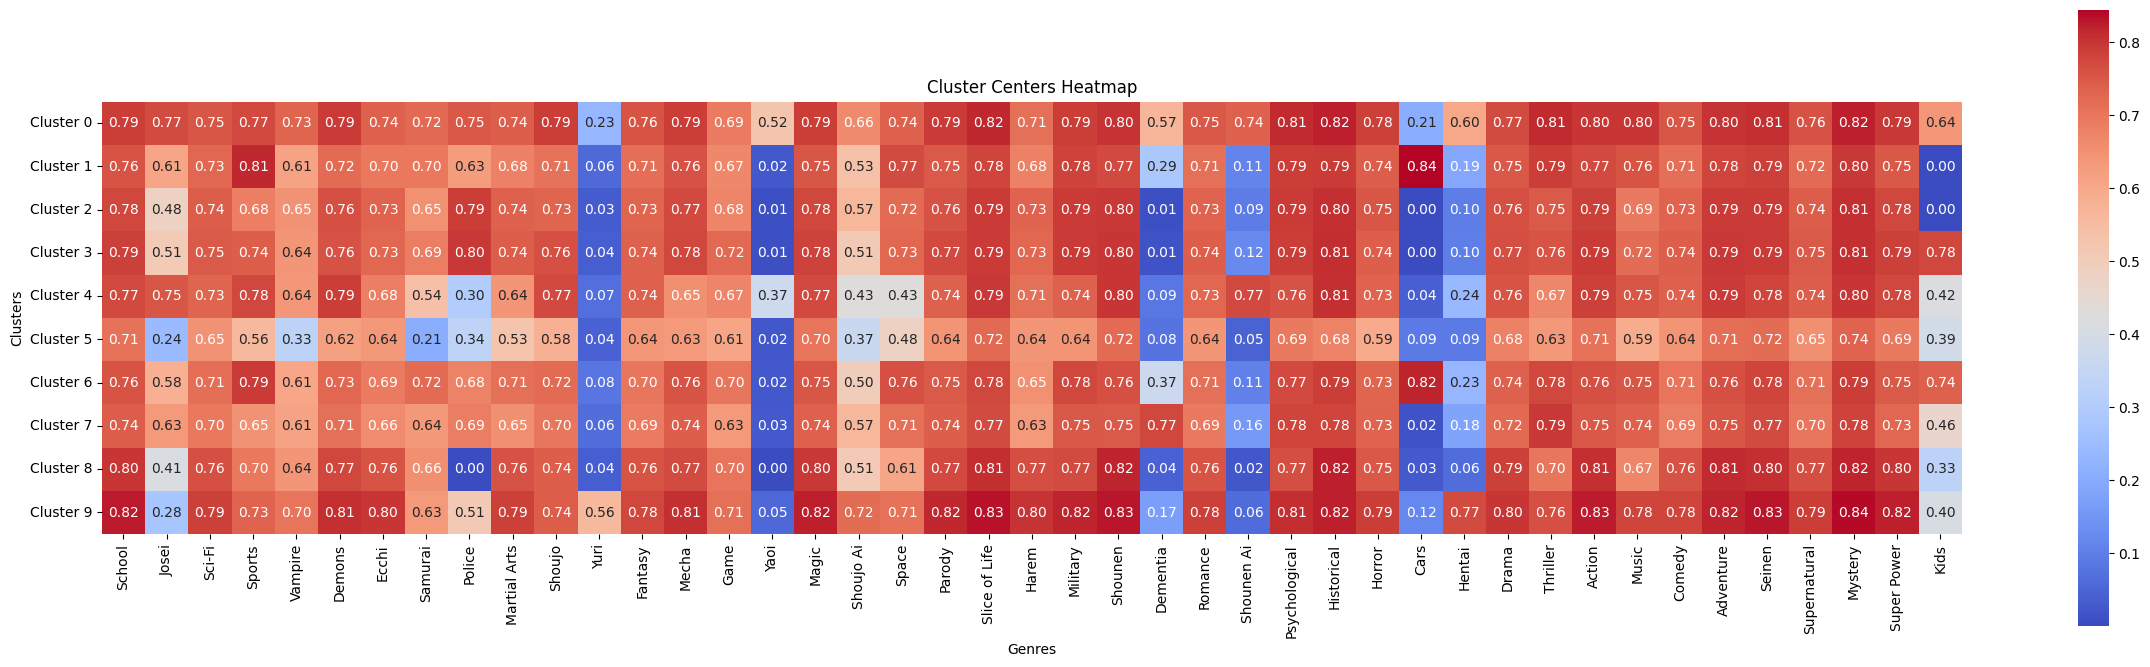

In [22]:
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns=df_scaled.columns[:-1])  # Без 'cluster'

plt.figure(figsize=(30, 8))
sns.heatmap(
    centroids_df, 
    annot=True,        # числа
    fmt=".2f",         # и их формат
    cmap="coolwarm",  
    xticklabels=True,  
    yticklabels=[f"Cluster {i}" for i in range(10)],
    square=True 
)
plt.title("Cluster Centers Heatmap")
plt.xlabel("Genres")
plt.ylabel("Clusters")
# plt.tight_layout() 
plt.show()

# Как выбрать нужное число кластеров

Такие методы как KMeans, Spectral clustering, Ward hierarchical clustering, Agglomerative clustering требуют количество кластеров как параметр. Это так называемый гипер-параметр, и его должен подбирать человек. Но на что человеку опираться при выборе? На некоторый функционал "качества"!

Вспомним идею кластеризации:
- минимизация внутрикластерного расстояния
- максимизация межкластерного расстояния

Другими словами - кучки кучнее и дальше друг от друга.

Логично, что мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого функционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента). Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Или более формально: $$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Где, в случае kMeans $$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$ - сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся

#### Эта ячейка может выполнятся долго!

In [23]:
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

100%|██████████| 29/29 [00:01<00:00, 15.27it/s]


Text(0, 0.5, '$J(C_k)$')

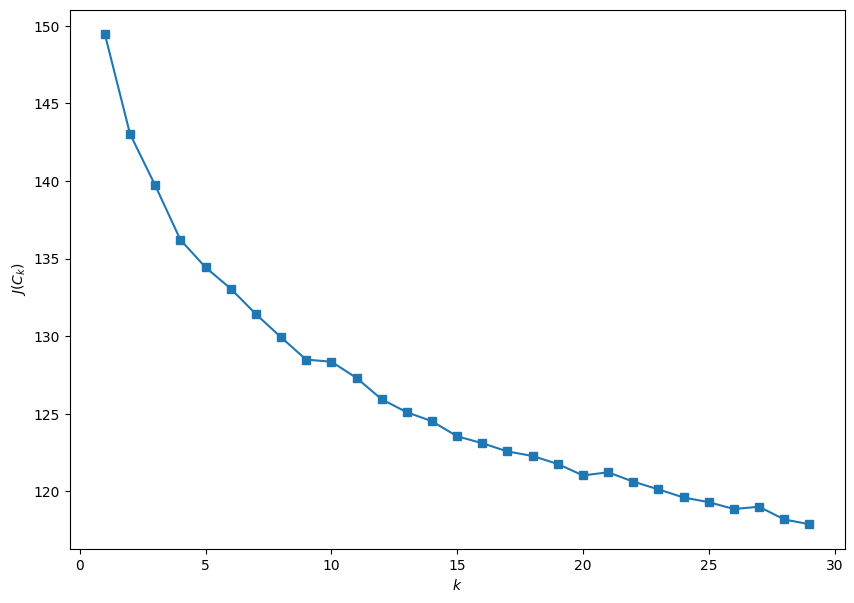

In [24]:
inertia = []
N = 30
for k in tqdm(range(1, N)):
    kmeans = KMeans(n_clusters=k).fit(scaler.fit_transform(df))
    inertia.append(np.sqrt(kmeans.inertia_))
plt.figure(figsize=(10,7))
plt.plot(range(1, N), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

## Коэффициент силуэта

Данный коэффициент не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации. 

Сначала силуэт определяется отдельно для каждого объекта. Обозначим через $a$ - среднее расстояние от данного объекта до объектов из того же кластера, через $b$ - среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина: $$s = \frac{b - a}{\max(a, b)}.$$ Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне $[-1, 1]$. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров $k$ (если оно заранее неизвестно) - выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

#### Эта ячейка может выполняться долго!

In [25]:
from sklearn.metrics import silhouette_score, silhouette_samples

def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20]):
    scores = []
    for n_clusters in tqdm(range_n_clusters):
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(range_n_clusters, scores)
    return range_n_clusters[np.argmax(scores)]

100%|██████████| 28/28 [00:54<00:00,  1.95s/it]


2

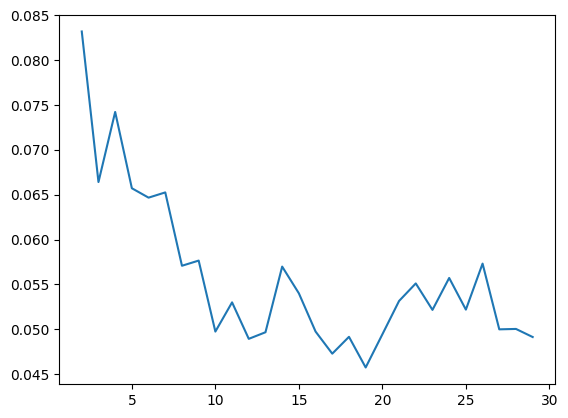

In [26]:
draw_sil_score(scaler.fit_transform(df), range(2, 30))

### 17. Выберите количество кластеров `k` по методам выше. Натренируйте kMeans и снова нарисуйте heatmap.

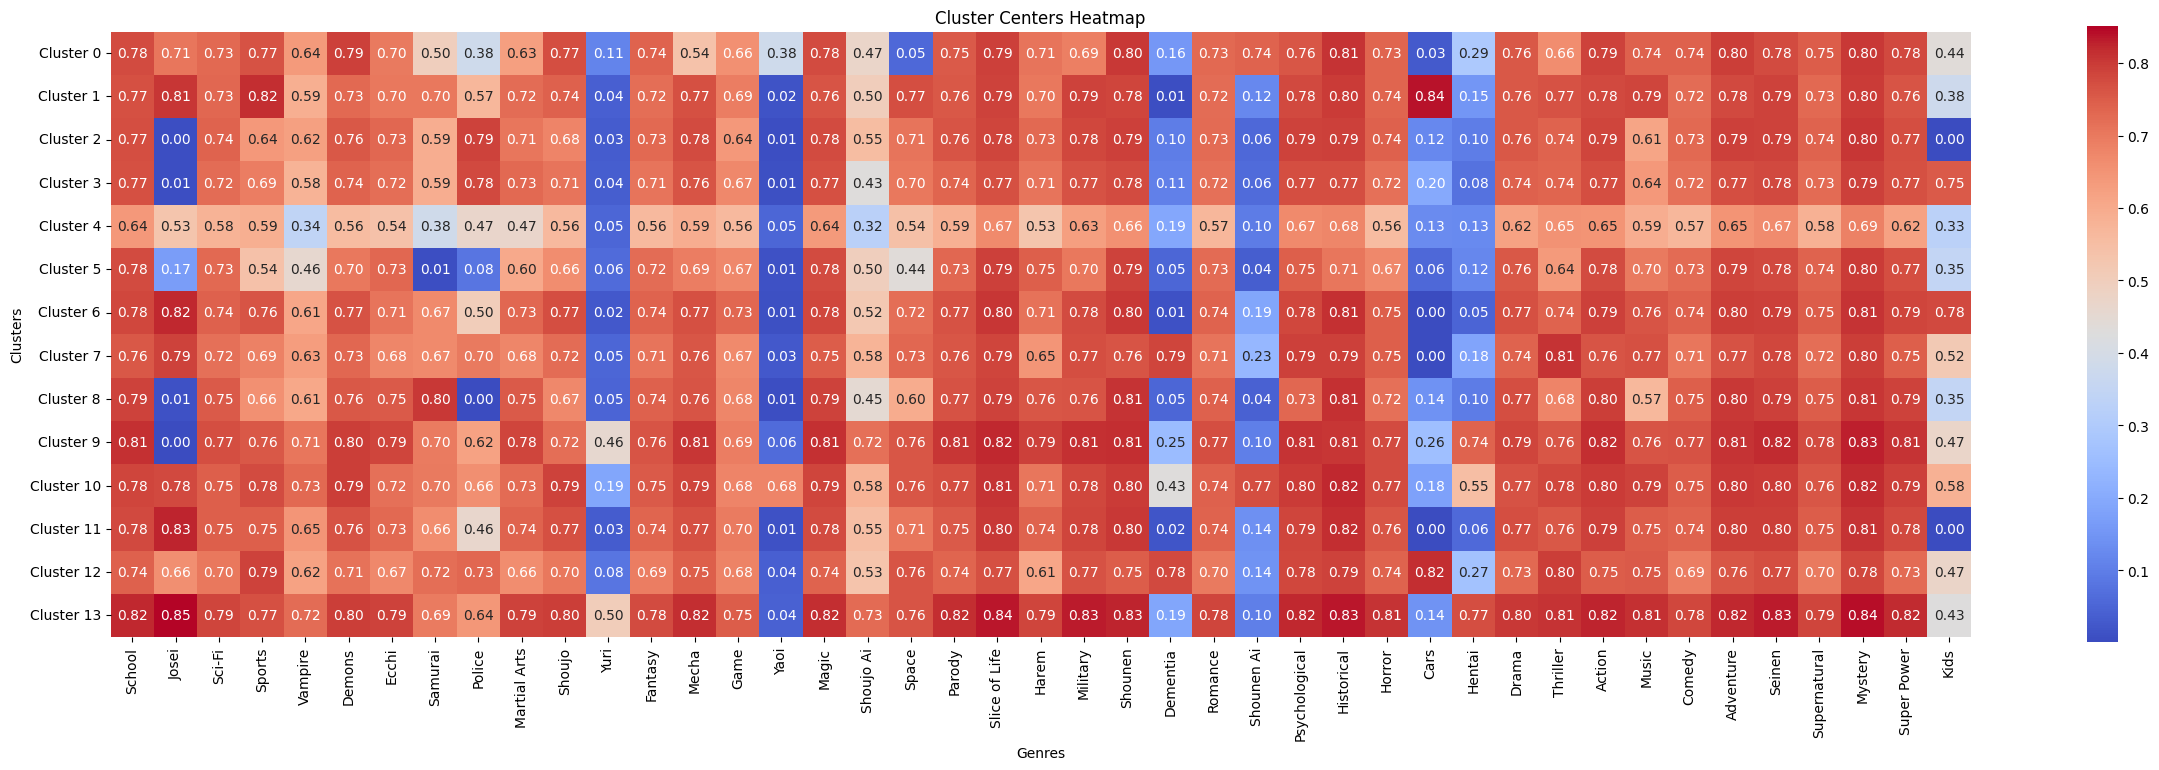

In [31]:
optimal_k = 14
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(df_scaled.drop(columns=['cluster'], errors='ignore'))

# Извлечение центров кластеров
centroids = kmeans.cluster_centers_


centroids_df_new = pd.DataFrame(centroids, columns=df_scaled.columns[:-1])  # Исключаем столбец 'cluster'

plt.figure(figsize=(30, 8))
sns.heatmap(
    centroids_df_new, 
    annot=True,        # числа
    fmt=".2f",         # и их формат
    cmap="coolwarm",  
    xticklabels=True,  
    yticklabels=[f"Cluster {i}" for i in range(optimal_k)],
    square=True 
)
plt.title("Cluster Centers Heatmap")
plt.xlabel("Genres")
plt.ylabel("Clusters")
plt.show()


### 18. Порекомендуйте что-нибудь абстрактному пользователю. 
Это можно сделать разными способами. Как это сделать подумайте сами. 

Если затрудняетесь реализовать это в коде, распишите словами как вы бы это сделали.

Возможные варианты решения:
 * в каждом кластере отсортировать жанры по тому, насколько жанр важен. 
 * взять каждый кластер -> получить все аниме, которые смотрят в этом кластере -> отсортировать по рейтину.



In [33]:
'''Если мы вообще ничео не знаем о пользователе, то можно взять анимешные выбросы с излишне высоким 
рейтином и кол-вом просмотров, потому что так мы сбольшой вероятностью посоветуем человеку то, что 
может зайти и при этом после просмотра получим отправную точку для построения следующих рекомендаций''' 

mean_rating = anime['rating'].mean()
mean_members = anime['members'].mean()

filtered_outlier_anime = outlier_anime[(outlier_anime['rating'] > mean_rating) & (outlier_anime['members'] > mean_members)]

# Выбираем случайную строку из отфильтрованных данных
random_row = filtered_outlier_anime.sample(n=1)

display(random_row)

,name,genre,type,episodes,rating,members
anime_id,,,,,,
1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917


In [34]:
import random # Чтобы был элемент случайнности

In [36]:
display(ratings.head(2))
display(df_scaled.head(2))

,user_id,anime_id,rating
97,5,6,8
98,5,15,6


,School,Josei,Sci-Fi,Sports,Vampire,Demons,Ecchi,Samurai,Police,Martial Arts,...,Action,Music,Comedy,Adventure,Seinen,Supernatural,Mystery,Super Power,Kids,cluster
user_id,,,,,,,,,,,,,,,,,,,,,
5,0.409560,0.727273,0.411877,0.626263,0.727273,0.469697,0.316986,0.717172,0.181818,0.433884,...,0.519743,0.556818,0.355651,0.560358,0.494715,0.361582,0.448485,0.490909,0.585227,5
7,0.719606,0.000000,0.701646,0.757576,0.727273,0.747475,0.709091,0.636364,0.727273,0.659091,...,0.747934,0.688312,0.696495,0.772727,0.742072,0.701525,0.802139,0.792208,0.848485,3


In [51]:
'''Рассмотрим ситуацию, когда у нас есть какая-то информация о пользователе'''
# Для каждого кластера вычисляем средний рейтинг аниме
cluster_ratings = df_scaled.copy()
df_scaled = df_scaled.drop(columns=['cluster'], errors='ignore')

ratings_with_clusters = ratings.merge(df_scaled, left_on='user_id', right_index=True)
ratings_with_clusters['cluster'] = kmeans.predict(df_scaled.loc[ratings_with_clusters['user_id']])

#  Посчитаем рейтинг по кластерам
cluster_ratings = ratings_with_clusters.groupby(['cluster', 'anime_id'])['rating'].mean().reset_index()

display(cluster_ratings.head(10))

,cluster,anime_id,rating
0,0,1,7.880952
1,0,5,6.000000
2,0,6,8.152174
3,0,7,7.214286
4,0,8,6.333333
5,0,15,8.379310
6,0,16,7.962963
7,0,17,7.833333
8,0,18,9.250000
9,0,19,9.413793


In [65]:
# Выбираем случайного пользователя из df_scaled
random_user = random.choice(df_scaled.index)
# и определяем ему кластер
user_cluster = kmeans.predict(df_scaled.loc[[random_user]])

print(random_user, user_cluster)

38937 [10]


In [66]:
# Получаем все аниме для выбранного кластера
cluster_animes = cluster_ratings[cluster_ratings['cluster'] == user_cluster[0]]

# Сортируем аниме по рейтингу от самого высокого к низкому
sorted_animes = cluster_animes.sort_values(by='rating', ascending=False)

for _, row in sorted_animes.iterrows():
    anime_id = row['anime_id']
    
    # Проверяем, оценил ли пользователь это аниме
    user_rating = ratings[(ratings['user_id'] == random_user) & (ratings['anime_id'] == anime_id)]
    
    if user_rating.empty:
        # Если пользователь не оценил аниме, выводим его информацию
        anime_info = anime.loc[anime_id]
        display(anime_info)
        print("Локальный рейтинг: ", row["rating"])
        break


name        Andes Shounen Pepero no Bouken
genre                            Adventure
type                                    TV
episodes                                26
rating                                6.92
members                                423
Name: 5104, dtype: object

Локальный рейтинг:  10.0


### Extra. Попробуйте как-нибудь улучшить эту рекомендашку. Приведите код или рассуждения на эту тему.

Если писать код, то можно:
 * каждому жанру присвоить свой вес, так как одних жанров сильно много и у них разная смысловая нагрузка. Комедии и экшн встречаются очень часто и врядли кто-то только из-за этих жанров будет смотреть аниме.
 * предсказывать не по жанрам, а по аниме. Там получится очень большая размерность, так как нужно сделать one-hot-encoding по аниме, но может это даст лучше результат(спойлер: нет). (И для этого надо сделать 4 join'а, что, возможно, убьет ваш компьютер или/и мозг)

In [ ]:
'''Рекомендашку можно улучшить, если каким-то образом усреднить значение локального внутри кластера рейтинга 
с объективной картиной, кроме того глупо не рекомендовать топовые аниме на основании того, что они являются
выбросами, поэтому можно включить в рекоммендации их, а так же высокооценённые аниме схожих кластеров 
(и просто новинки, ведь их тоже надо кому-то оценивать)'''